In [9]:
import pypsa
import networkx as nx
import matplotlib.pyplot as plt

In [10]:
def plot_network(network):
    # Convert PyPSA network to a NetworkX graph
    G = nx.Graph()

    # Add nodes with attributes
    for bus in network.buses.index:
        load = network.loads[network.loads["bus"] == bus]["p_set"].sum()
        generators = network.generators[network.generators["bus"] == bus]["p_nom"].sum()
        G.add_node(bus, pos=(network.buses.loc[bus, "x"], network.buses.loc[bus, "y"]), load=load, generators=generators)

    # Add edges
    for line in network.lines.index:
        G.add_edge(network.lines.loc[line, "bus0"],
                network.lines.loc[line, "bus1"],
                weight=network.lines.loc[line, "length"])

    # Extract positions for nodes
    positions = nx.get_node_attributes(G, "pos")
    loads = nx.get_node_attributes(G, "load")
    generators = nx.get_node_attributes(G, "generators")

    # Draw the graph
    plt.figure(figsize=(10, 7))

    # Draw edges
    nx.draw(
        G,
        pos=positions,
        with_labels=True,
        node_color="lightblue",
        edge_color="gray",
        node_size=700,
        font_size=10,
        font_color="white",
    )

    # Draw loads as red balls and dotted lines
    for node, (x, y) in positions.items():
        load_value = loads[node]
        if load_value > 0:  # Only draw if there's a load
            # Offset position for the load
            load_x, load_y = x - 0.05, y - 0.2

            # Draw the load as a red ball
            plt.scatter(
                load_x, load_y,
                s=50,  # Size of the ball
                color="red"
            )

            # Draw a dotted line connecting the bus to the load
            plt.plot(
                [x, load_x], [y, load_y],
                linestyle="dotted",
                color="black",
                linewidth=1
            )

    # Draw generators as green triangles and dotted lines
    for node, (x, y) in positions.items():
        generator_value = generators[node]
        if generator_value > 0:  # Only draw if there's a generator
            # Offset position for the generator
            gen_x, gen_y = x + 0.0, y + 0.3

            # Draw the generator as a green triangle
            plt.scatter(
                gen_x, gen_y,
                s=300,  # Size of the triangle
                color="green",
                marker="^"  # Triangle marker
            )

            # Draw a dotted line connecting the bus to the generator
            plt.plot(
                [x, gen_x], [y, gen_y],
                linestyle="dotted",
                color="black",
                linewidth=1
            )

    # Add legend for loads and generators
    handles = [
        plt.Line2D([0], [0], marker="o", color="red", label="Load", markersize=6, linestyle="None"),
        plt.Line2D([0], [0], marker="^", color="green", label="Generator", markersize=8, linestyle="None")
    ]
    plt.legend(handles=handles, loc="upper right")

    plt.title("PyPSA Network with Loads and Generators")
    plt.show()

In [25]:
# Create a new network
network = pypsa.Network()

# Add buses (nodes)
# Add buses (nodes)
network.add("Bus", "bus1", v_nom=230, x=0, y=0)  # Nominal voltage 230 kV, Location (0, 0)
network.add("Bus", "bus2", v_nom=230, x=1, y=0.5)  # Location (1, 1)
network.add("Bus", "bus3", v_nom=230, x=-1, y=1)  # Location (-1, 1)

# Add AC lines connecting the buses
network.add(
    "Line",
    "line1",
    bus0="bus1",
    bus1="bus2",
    x=0.1,  # Reactance in p.u.
    r=0.01, # Resistance in p.u.
    s_nom=100,  # Nominal power capacity in MVA
)

network.add(
    "Line",
    "line2",
    bus0="bus2",
    bus1="bus3",
    x=0.1,
    r=0.01,
    s_nom=100,
)

network.add(
    "Line",
    "line3",
    bus0="bus3",
    bus1="bus1",
    x=0.1,
    r=0.01,
    s_nom=100,
)

# Add generators at each bus
network.add(
    "Generator",
    "gen1",
    bus="bus1",
    p_nom=50,  # Nominal power in MW
    marginal_cost=20,  # Cost in $/MWh
)

# network.add(
#     "Generator",
#     "gen2",
#     bus="bus2",
#     p_nom=50,
#     marginal_cost=25,
# )

# network.add(
#     "Generator",
#     "gen3",
#     bus="bus3",
#     p_nom=50,
#     marginal_cost=30,
# )

# Add loads at each bus
network.add(
    "Load",
    "load1",
    bus="bus1",
    p_set=10,  # Power demand in MW
)

network.add(
    "Load",
    "load2",
    bus="bus2",
    p_set=10,
)

network.add(
    "Load",
    "load3",
    bus="bus3",
    p_set=20,
)

# Optimize the network
network.optimize()

# Print results
print("Bus voltages:")
print(network.buses_t.v_ang)
print()
print("Line flows:")
print(network.lines_t.p0)


Index(['bus1', 'bus2', 'bus3'], dtype='object', name='Bus')
Index(['line1', 'line2', 'line3'], dtype='object', name='Line')
Index(['bus1', 'bus2', 'bus3'], dtype='object', name='Bus')
Index(['line1', 'line2', 'line3'], dtype='object', name='Line')
/home/heikern/miniconda3/envs/mesh_viz/lib/python3.12/site-packages/linopy/common.py:154: UserWarning: coords for dimension(s) ['Generator'] is not aligned with the pandas object. Previously, the indexes of the pandas were ignored and overwritten in these cases. Now, the pandas object's coordinates are taken considered for alignment.
  warn(
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.01s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 4 primals, 12 duals
Objective: 8.00e+02
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Line-fix-s-low

Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [2e-01, 1e+00]
  Cost   [2e+01, 2e+01]
  Bound  [0e+00, 0e+00]
  RHS    [1e+01, 1e+02]
Presolving model
0 rows, 0 cols, 0 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve : Reductions: rows 0(-12); columns 0(-4); elements 0(-18) - Reduced to empty
Solving the original LP from the solution after postsolve
Model name          : linopy-problem-dck5rd34
Model status        : Optimal
Objective value     :  8.0000000000e+02
Relative P-D gap    :  0.0000000000e+00
HiGHS run time      :          0.00
Writing the solution to /tmp/linopy-solve-jk4kc20y.sol
Bus voltages:
Bus           bus1      bus2      bus3
snapshot                              
now       0.000019 -0.000006 -0.000013

Line flows:
Line          line1     line2      line3
snapshot                                
now       13.333333  3.333333 -16.666667


In [ ]:
# Access the optimization problem
lp_model = network.lp

# Print all constraints
print("Constraints in the optimization problem:")
for constraint in lp_model.constraints:
    print(f"{constraint.name}: {constraint.expression}")

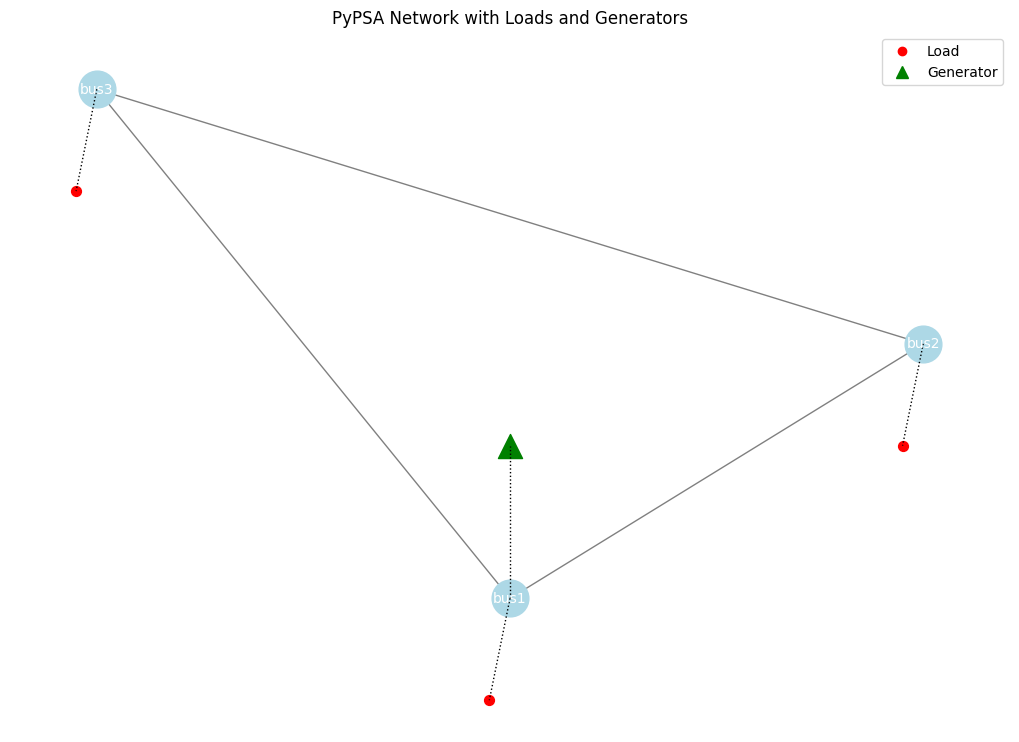

In [26]:
plot_network(network)

In [11]:
# Output the network to verify
print(network)

PyPSA Network
Components:
 - Bus: 5
 - Generator: 2
 - Line: 7
 - Load: 5
Snapshots: 1


In [5]:
network.model

AttributeError: 'Network' object has no attribute 'model'

In [12]:
# Solve the network's optimal power flow (OPF)
network.lpf(network.snapshots)

INFO:pypsa.pf:Performing linear load-flow on AC sub-network <pypsa.components.SubNetwork object at 0x12e83b0e0> for snapshot(s) Index(['2024-01-01 00:00'], dtype='object', name='snapshot')


In [13]:
# Print results for generators and loads
print(network.generators_t.p)  # Generator outputs
print(network.loads_t.p)       # Load power consumptions

Generator         Generator 1  Generator 2
snapshot                                  
2024-01-01 00:00        250.0          0.0
Load              Load 1  Load 2  Load 3  Load 4  Load 5
snapshot                                                
2024-01-01 00:00    50.0    50.0    50.0    50.0    50.0
